In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from glob import glob
from tqdm import tqdm

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# create directory paths for images (from dataset)
base_dir = '../../overview/project_data/COMPLETE_DATASET'
train_dir = path.join(base_dir, 'TRAIN')
test_dir = path.join(base_dir, 'TEST')

print(train_dir)
print(test_dir)

../../overview/project_data/COMPLETE_DATASET/TRAIN
../../overview/project_data/COMPLETE_DATASET/TEST


# EDA

In [3]:
# .jpg files of organic images from train data
train_org = glob(path.join(train_dir, 'O', '*.jpg'))
print('Number of organic (train) images: ', len(train_org))

Number of organic (train) images:  12565


In [4]:
# .jpg files of recyclable images from train data
train_re = glob(path.join(train_dir, 'R', '*.jpg'))
print('Number of recyclable (train) images: ', len(train_re))

Number of recyclable (train) images:  9999


In [5]:
# .jpg files of organic images from train data
test_org = glob(path.join(test_dir, 'O', '*.jpg'))
print('Number of organic (test) images: ', len(test_org))

Number of organic (test) images:  1401


In [6]:
# .jpg files of organic images from train data
test_re = glob(path.join(test_dir, 'R', '*.jpg'))
print('Number of recyclable (test) images: ', len(test_re))

Number of recyclable (test) images:  1112


In [7]:
print('Number of total (train + test) images: ', len(train_org)+len(train_re)+len(test_org)+len(test_re))
print('Number of train (organic + recyclable) images: ', len(train_org)+len(train_re))
print('Number of test (organic + recyclable) images: ', len(test_org)+len(test_re))

Number of total (train + test) images:  25077
Number of train (organic + recyclable) images:  22564
Number of test (organic + recyclable) images:  2513


In [8]:
x_data = []
y_data = []

for folder in glob(path.join(train_dir, '*')):
    for file in tqdm(glob(path.join(folder, '*.jpg'))):
        img_array = plt.imread(file)
        x_data.append(img_array)
        y_data.append(folder.split('/')[-1])

train_data = pd.DataFrame({'image': x_data, 'label': y_data})

100%|██████████████████████████████████████████████████████████████████| 12565/12565 [00:19<00:00, 652.27it/s]


In [9]:
train_data.shape

(22564, 2)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB


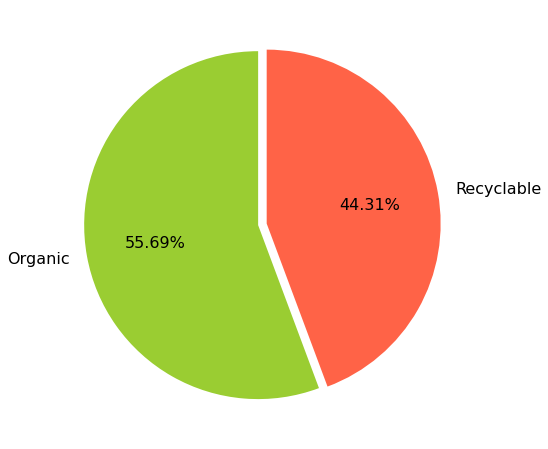

In [11]:
# class distribution
plt.figure(figsize=(8,8))
plt.pie(train_data.label.value_counts(), 
        explode=[0.025,0.025],
        colors=['yellowgreen', 'tomato'],
        labels=['Organic', 'Recyclable'],
        autopct='%.2f%%',
        startangle=90,
        textprops={'fontsize':16})
plt.savefig('../04_data_visualizations/class_balance.png')
plt.show()

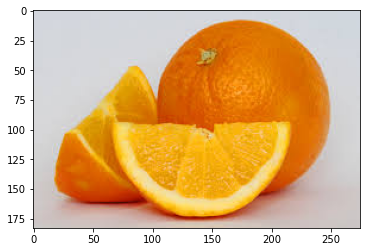

In [12]:
# read and display organic image
plt.imshow(plt.imread(train_org[8]))

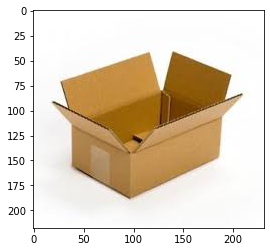

In [13]:
# read and display recyclable images
plt.imshow(plt.imread(train_re[1]))

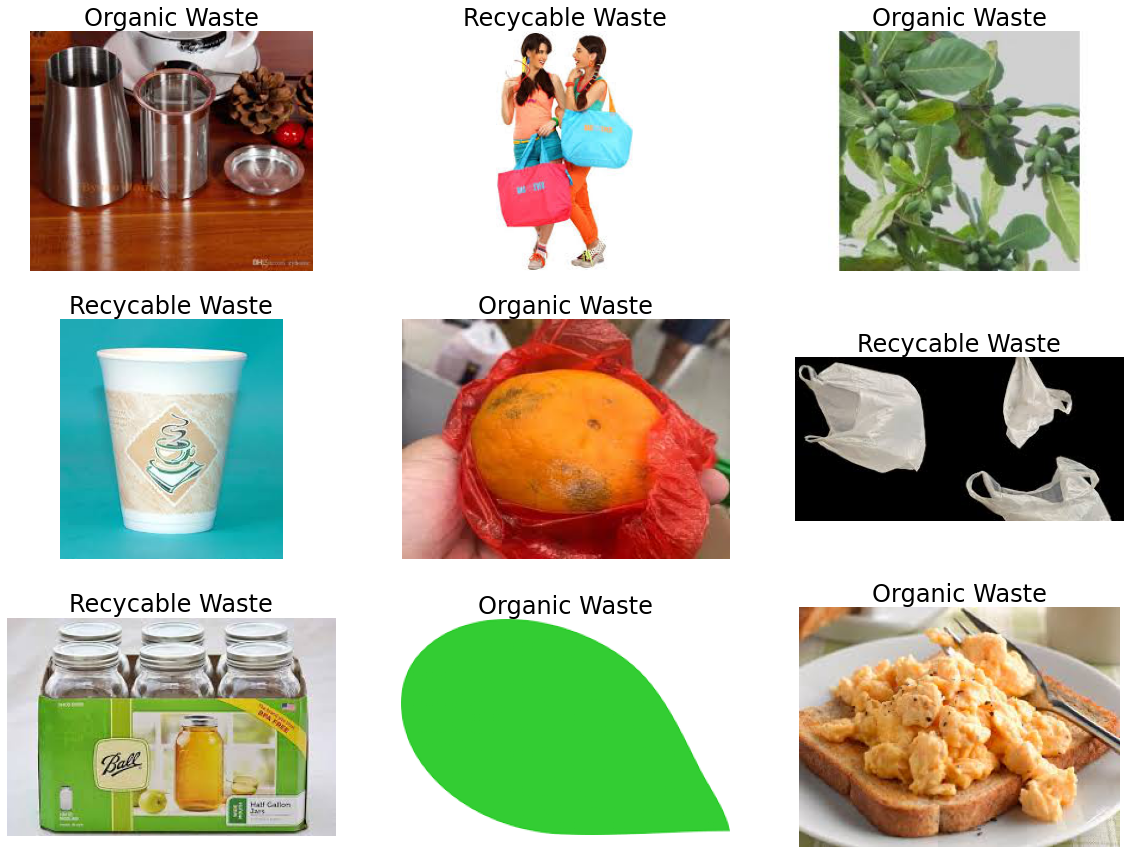

In [14]:
# display random class images
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%12)+1)
    index=np.random.randint(22000)
    
    plt.imshow(train_data.image[index])
    plt.axis('off')
    
    if train_data.label[index] == 'O':
        plt.title('Organic Waste', fontdict={'size':24})
    else:
        plt.title('Recycable Waste', fontdict={'size':24})

plt.savefig('../04_data_visualizations/images_from_dataset.png')     
plt.show()

In [15]:
# return shape for first 10 organic images
for img in train_org[0:10]:
    print((plt.imread(img)).shape)

(225, 225, 3)
(224, 224, 3)
(191, 264, 3)
(168, 300, 3)
(183, 276, 3)
(240, 210, 3)
(194, 259, 3)
(195, 258, 3)
(183, 275, 3)
(183, 276, 3)


In [16]:
# return shape for first 10 recyclable images
for img in train_re[0:10]:
    print((plt.imread(img)).shape)

(168, 300, 3)
(218, 231, 3)
(225, 225, 3)
(133, 380, 3)
(177, 284, 3)
(177, 285, 3)
(267, 189, 3)
(169, 297, 3)
(275, 183, 3)
(275, 183, 3)


# IMAGE PREPROCESSING

In [17]:
img_height = 256
img_width = 256
batch_size = 32

In [18]:
# image scaling
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [19]:
# initialize train, testing generator
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [20]:
train_generator.class_indices

{'O': 0, 'R': 1}

In [21]:
# iterate batches -> store the data in x_train, y_train
train_generator.reset()
x_train, y_train = next(train_generator)

#1st batch is already fetched before the for loop
for i in tqdm(range(int(len(train_generator)/32)-1)): 
    img, label = next(train_generator)
    x_train = np.append(x_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

100%|█████████████████████████████████████████████████████████████████████████| 21/21 [00:05<00:00,  4.14it/s]

(704, 256, 256, 3) (704,)


In [22]:
# iterate batches -> store the data in x_test, y_test
test_generator.reset()
x_test, y_test = next(test_generator)

#1st batch is already fetched before the for loop.
for i in tqdm(range(int(len(test_generator)/32)-1)): 
    img, label = next(test_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(x_test.shape, y_test.shape)

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]

(64, 256, 256, 3) (64,)


# NON DEEP LEARNING MODELS

In [23]:
print(x_train.ndim)
print(x_test.ndim)

4
4


In [24]:
# reshape x_train values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_train.shape
x_train_2d = x_train.reshape((nsamples,nx*ny*nrgb))

In [25]:
# reshape x_test values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_test.shape
x_test_2d = x_test.reshape((nsamples,nx*ny*nrgb))

## RANDOM FOREST CLASSIFIER

In [26]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_2d)
x_train_2pc = pca.transform(x_train_2d)

# reduce test data dimensions using PCA
pca.fit(x_test_2d)
x_test_2pc = pca.transform(x_test_2d)

print(np.shape(x_train_2pc))
print(np.shape(x_test_2pc))

(704, 2)
(64, 2)


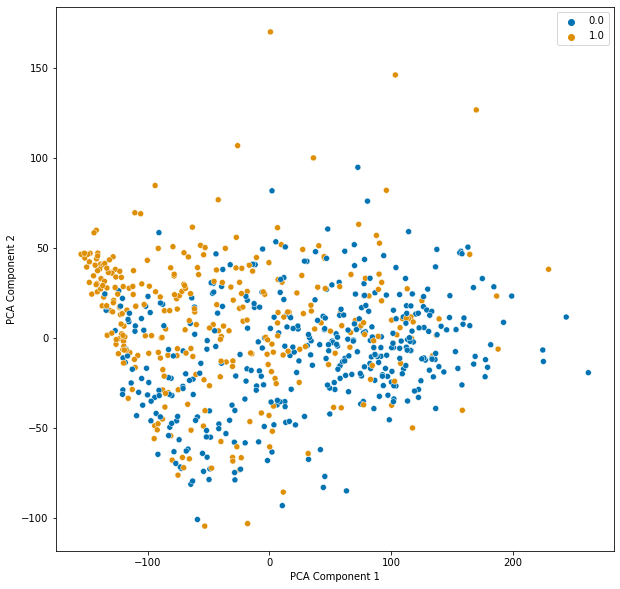

In [27]:
# plot PCA 
plt.figure(figsize=(10,10))

sns.scatterplot(x=x_train_2pc[:, 0], y=x_train_2pc[:, 1],
                hue=y_train,
                palette=sns.color_palette("colorblind", 2))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.savefig('../04_data_visualizations/pca_plot.png')
plt.show()

In [28]:
# instantiate and fit non deep learning model
rf = RandomForestClassifier()
rf.fit(x_train_2pc,y_train)

RandomForestClassifier()

In [29]:
# predict target values
rf_y_pred = rf.predict(x_test_2pc)
rf_y_pred[0:10]

array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0.], dtype=float32)

In [31]:
# evaluate metrics
print(f"Random Forest MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

Random Forest MAE: 0.4844
Random Forest MSE: 0.4844
Random Forest Accuracy: 0.5156


In [32]:
# loss score for random forest?

## LOGISTIC REGRESSION

In [33]:
# standardized values for logistic regression
sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train_2d)
x_test_scaled = sc.transform(x_test_2d)

In [34]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_scaled)
x_train_scaled_2pc = pca.transform(x_train_scaled)

# reduce test data dimensions using PCA
pca.fit(x_test_scaled)
x_test_scaled_2pc = pca.transform(x_test_scaled)

print(np.shape(x_train_scaled_2pc))
print(np.shape(x_test_scaled_2pc))

(704, 2)
(64, 2)


In [35]:
# instantiate and fit logistic regression
lr = LogisticRegression()
lr.fit(x_train_scaled_2pc, y_train)

LogisticRegression()

In [36]:
# predict target values
lr_y_pred = lr.predict(x_test_scaled_2pc)
lr_y_pred[0:10]

array([1., 1., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [37]:
# evaluate metrics
print(f"Logistic Regression MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Logistic Regression MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Logistic Regression Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

Logistic Regression MAE: 0.4844
Logistic Regression MSE: 0.4844
Logistic Regression Accuracy: 0.5156


In [38]:
# loss score for logistic regression?